In [1]:
import polars as pl
import sqlite3

conn = sqlite3.connect('new_data/dota_2_data_2025_08_27.db')

In [2]:
heroes_df = pl.read_database("SELECT * FROM hero_info", conn)
print(heroes_df)

teams_df = pl.read_database("SELECT * FROM team_info", conn)
print(teams_df)

matches_df = pl.read_database("SELECT * FROM match_info", conn)
print(matches_df)

players_df = pl.read_database("SELECT * FROM player_info", conn)
print(players_df)

leagues_df = pl.read_database("SELECT * FROM league_info", conn)
print(leagues_df)

conn.close()

shape: (126, 6)
┌─────────┬────────────────┬─────────────┬───────────────────┬─────────────────┬─────────────────┐
│ hero_id ┆ hero_name      ┆ attack_type ┆ primary_attribute ┆ base_attack_min ┆ base_attack_max │
│ ---     ┆ ---            ┆ ---         ┆ ---               ┆ ---             ┆ ---             │
│ i64     ┆ str            ┆ str         ┆ str               ┆ i64             ┆ i64             │
╞═════════╪════════════════╪═════════════╪═══════════════════╪═════════════════╪═════════════════╡
│ 1       ┆ Anti-Mage      ┆ Melee       ┆ agi               ┆ 29              ┆ 33              │
│ 2       ┆ Axe            ┆ Melee       ┆ str               ┆ 31              ┆ 35              │
│ 3       ┆ Bane           ┆ Ranged      ┆ all               ┆ 24              ┆ 30              │
│ 4       ┆ Bloodseeker    ┆ Melee       ┆ agi               ┆ 35              ┆ 41              │
│ 5       ┆ Crystal Maiden ┆ Ranged      ┆ int               ┆ 30              ┆ 36          

In [3]:
main_df = matches_df.join(players_df, on='player_account_id', how='left')
main_df = main_df.join(heroes_df, on='hero_id', how='left')
main_df = main_df.join(leagues_df, on='league_id', how='left')
main_df = main_df.join(teams_df, left_on='player_team_id', right_on='team_id', how='left')

print(main_df)

shape: (10_800, 25)
┌───────────┬────────────┬────────────┬─────────┬───┬────────────┬───────────┬───────────┬─────────┐
│ league_id ┆ match_id   ┆ player_acc ┆ hero_id ┆ … ┆ tier       ┆ patch_id_ ┆ team_name ┆ rating  │
│ ---       ┆ ---        ┆ ount_id    ┆ ---     ┆   ┆ ---        ┆ right     ┆ ---       ┆ ---     │
│ i64       ┆ i64        ┆ ---        ┆ i64     ┆   ┆ str        ┆ ---       ┆ str       ┆ f64     │
│           ┆            ┆ i64        ┆         ┆   ┆            ┆ i64       ┆           ┆         │
╞═══════════╪════════════╪════════════╪═════════╪═══╪════════════╪═══════════╪═══════════╪═════════╡
│ 16935     ┆ 7944311818 ┆ 91730177   ┆ 136     ┆ … ┆ premium    ┆ 56        ┆ Gaimin    ┆ 1322.47 │
│           ┆            ┆            ┆         ┆   ┆            ┆           ┆ Gladiator ┆         │
│           ┆            ┆            ┆         ┆   ┆            ┆           ┆ s         ┆         │
│ 16935     ┆ 7944311818 ┆ 116934015  ┆ 21      ┆ … ┆ premium    ┆ 56  

## Preprocessing

In [4]:
# Get number of entries for a certain match_Id
match_counts = main_df.group_by("match_id").agg(
    pl.col("match_id").count().alias("match_count")
)

match_ids_with_less_than_10_rows = match_counts.filter(pl.col("match_count") != 10).select("match_id").to_series().to_list()
# Remove matches with less than 10 rows
main_df = main_df.filter(~pl.col("match_id").is_in(match_ids_with_less_than_10_rows))

main_df.shape


(10800, 25)

In [5]:
# Get match_info entries where assumed_lane_role is different than the median assumed_lane_role by more than 1
player_medians = main_df.group_by("player_account_id").agg(
    pl.col("assumed_lane_role").median().alias("player_median")
).with_columns(
    pl.col("player_median").cast(pl.Float64)
)

# Join with main_df
preprocessed_main_df = main_df.join(
    player_medians, 
    on="player_account_id", 
    how="left"
)

# Filter out rows where assumed_lane_role is different than the median assumed_lane_role by more than 1
# EXCEPT when player_median == 1 and assumed_lane_role == 3
match_ids_with_wrong_roles = preprocessed_main_df.filter(
    # Find rows where role is outside ±1 of median
    (pl.col("assumed_lane_role") > pl.col("player_median") + 1) | 
    (pl.col("assumed_lane_role") < pl.col("player_median") - 1)
).select("match_id").unique().to_series().to_list()

# Get match IDs with a trilane (heroes_on_lane split (,) is larger than 2)
match_ids_with_trilane = main_df.filter(pl.col("heroes_on_lane").str.split(',').list.len() > 2).select("match_id").unique().to_series().to_list()

In [6]:
# Filter out matches with wrong roles or with trilane
matches_to_remove = match_ids_with_wrong_roles + match_ids_with_trilane

more_preprocessed_main_df = preprocessed_main_df.filter(
    ~pl.col("match_id").is_in(matches_to_remove)
)

preprocessed_main_df.shape, more_preprocessed_main_df.shape

((10800, 26), (10050, 26))

In [7]:
# Smart hero splitting based on role positions in Dota 2
# Core heroes (pos 1-3) face each other, supports (pos 4-5) face each other
# Position mapping: 1 <-> 3, 2 <-> 2, 4 <-> 5, 5 <-> 4

def get_role_counterpart(role):
    """Get the opposing role for a given position"""
    role_mapping = {
        1.0: 3.0,    # Safe lane carry <-> Offlaner
        2.0: 2.0,    # Mid <-> Mid  
        3.0: 1.0,    # Offlaner <-> Safe lane carry
        4.0: 5.0,    # Support <-> Support (harder support vs soft support)
        4.5: 4.5,    # Roaming support <-> Roaming support
        5.0: 4.0,    # Support <-> Support (soft support vs harder support)
        # Also include integer versions for backward compatibility
        1: 3.0, 2: 2.0, 3: 1.0, 4: 5.0, 5: 4.0
    }
    return role_mapping.get(role, role)

def is_core_role(role):
    """Determine if a role is core (1-3) or support (4-5, including 4.5)"""
    return role in [1.0, 2.0, 3.0, 1, 2, 3]  # Handle both int and float versions

def is_support_role(role):
    """Determine if a role is support (4, 4.5, 5)"""
    return role in [4.0, 4.5, 5.0, 4, 5]  # Handle both int and float versions

# Create a comprehensive dataframe with all match participants
# This allows us to find allies and enemies by match and team
match_participants = preprocessed_main_df.select([
    'match_id', 'hero_id', 'hero_name', 'assumed_lane_role', 
    'is_radiant', 'player_account_id'
]).with_columns([
    pl.col('assumed_lane_role').cast(pl.Float32)  # Keep as float to handle 4.5 roles
])

def get_lane_ally(heroes_on_lane_str, current_hero_name):
    """Get the lane partner from the heroes_on_lane string"""
    if not heroes_on_lane_str:
        return "Unknown"
    
    heroes = [hero.strip() for hero in heroes_on_lane_str.split(',')]
    # Filter out current hero to get lane partner
    allies = [hero for hero in heroes if hero != current_hero_name]
    
    return allies[0] if allies else "Unknown"



def get_smart_heroes(match_id, current_hero_id, current_role, is_radiant, heroes_on_lane_str, enemy_heroes_on_lane_str, current_hero_name):
    """
    Get ally and enemy heroes based on role intelligence
    Returns: [lane_ally_name, enemy_counterpart_name, enemy_secondary_name]
    """
    # Get lane ally from the heroes_on_lane data (actual lane partner)
    lane_ally = get_lane_ally(heroes_on_lane_str, current_hero_name)
    
    # Simple extraction from enemy_heroes_on_lane string
    if not enemy_heroes_on_lane_str:
        return [lane_ally, "Unknown", "Unknown"]
    
    enemy_names = [hero.strip() for hero in enemy_heroes_on_lane_str.split(',')]
    
    # Get role information for enemy heroes from match data
    match_heroes = match_participants.filter(pl.col('match_id') == match_id)
    lane_enemies = []
    
    for enemy_name in enemy_names:
        assert enemy_name != "Unknown"
        enemy_info = match_heroes.filter(pl.col('hero_name') == enemy_name)
        if len(enemy_info) > 0:
            enemy_role = enemy_info.row(0, named=True)['assumed_lane_role']
            lane_enemies.append((enemy_name, enemy_role))
    
    assert len(enemy_names) == len(lane_enemies), f"In match {match_id}, {enemy_names} has {len(enemy_names)} enemies, but {lane_enemies} has {len(lane_enemies)}"
    
    if not lane_enemies:
        # Fallback: use enemy names without role info
        return [lane_ally, enemy_names[0] if enemy_names else "Unknown", 
                enemy_names[1] if len(enemy_names) > 1 else "Unknown"]
    
    # Put the enemy roles in order of core and support
    core_enemies = [enemy for enemy in lane_enemies if is_core_role(enemy[1])]
    support_enemies = [enemy for enemy in lane_enemies if is_support_role(enemy[1])]
    
    # Filter out any "Unknown" heroes (though this shouldn't happen with the lane data)
    filtered_core_enemies = [enemy for enemy in core_enemies if enemy[0] != 'Unknown']
    filtered_support_enemies = [enemy for enemy in support_enemies if enemy[0] != 'Unknown']
    
    # Debug assertion - let's see what's happening when it fails
    if len(filtered_core_enemies) + len(filtered_support_enemies) != len(lane_enemies):
        print(f"Debug - Lane composition issue:")
        print(f"  All lane enemies: {lane_enemies}")
        print(f"  Core enemies: {core_enemies}")
        print(f"  Support enemies: {support_enemies}")
        print(f"  Filtered cores: {filtered_core_enemies}")
        print(f"  Filtered supports: {filtered_support_enemies}")
        print(f"  Total lane enemies: {len(lane_enemies)}")
        print(f"  Filtered total: {len(filtered_core_enemies) + len(filtered_support_enemies)}")
    
    # The correct assertion should be that filtered cores + filtered supports = total lane enemies
    assert len(filtered_core_enemies) + len(filtered_support_enemies) == len(lane_enemies), \
        f"Role classification mismatch: {len(filtered_core_enemies)} cores + {len(filtered_support_enemies)} supports != {len(lane_enemies)} total"
    
    # Debug when we're missing core enemies (leading to "Unknown3")
    if len(filtered_core_enemies) == 0 and len(lane_enemies) > 0:
        print(f"Debug - No core enemies found in lane:")
        print(f"  Enemy lane string: {enemy_heroes_on_lane_str}")
        print(f"  All lane enemies: {lane_enemies}")
        for enemy_name, enemy_role in lane_enemies:
            print(f"    {enemy_name}: role {enemy_role}, type {type(enemy_role)}, is_core: {is_core_role(enemy_role)}")
            print(f"      Raw role value: {repr(enemy_role)}")
    
    return [lane_ally, 
            filtered_core_enemies[0][0] if len(filtered_core_enemies) > 0 else "Unknown3", 
            filtered_support_enemies[0][0] if len(filtered_support_enemies) > 0 else "Unknown"]

# Apply the smart hero assignment
print("Applying smart hero splitting based on Dota 2 role counterparts...")

# We'll process this row by row since we need to access other rows in the same match
results = []
for row in more_preprocessed_main_df.iter_rows(named=True):
    hero_assignments = get_smart_heroes(
        row['match_id'], 
        row['hero_id'], 
        float(row['assumed_lane_role']),  # Keep as float to handle 4.5
        row['is_radiant'],
        row['heroes_on_lane'],  # Pass the lane heroes string
        row['enemy_heroes_on_lane'],  # Pass the enemy lane heroes string
        row['hero_name']  # Pass current hero name for filtering
    )
    results.append(hero_assignments)

# Convert results to polars format and add to dataframe
results_df = pl.DataFrame({
    'lane_partner': [r[0] for r in results],
    'enemy_core': [r[1] for r in results], 
    'enemy_support': [r[2] for r in results]
})

preprocessed_main_df = more_preprocessed_main_df.with_columns([
    results_df['lane_partner'].alias('lane_partner'),
    results_df['enemy_core'].alias('enemy_core'),
    results_df['enemy_support'].alias('enemy_support')
])


print("Smart hero splitting completed!")
preprocessed_main_df

Applying smart hero splitting based on Dota 2 role counterparts...
Debug - No core enemies found in lane:
  Enemy lane string: Venomancer, Nyx Assassin
  All lane enemies: [('Venomancer', 4.0), ('Nyx Assassin', 4.0)]
    Venomancer: role 4.0, type <class 'float'>, is_core: False
      Raw role value: 4.0
    Nyx Assassin: role 4.0, type <class 'float'>, is_core: False
      Raw role value: 4.0
Debug - No core enemies found in lane:
  Enemy lane string: Venomancer, Nyx Assassin
  All lane enemies: [('Venomancer', 4.0), ('Nyx Assassin', 4.0)]
    Venomancer: role 4.0, type <class 'float'>, is_core: False
      Raw role value: 4.0
    Nyx Assassin: role 4.0, type <class 'float'>, is_core: False
      Raw role value: 4.0
Debug - No core enemies found in lane:
  Enemy lane string: Windranger, Beastmaster
  All lane enemies: [('Windranger', 4.0), ('Beastmaster', 4.0)]
    Windranger: role 4.0, type <class 'float'>, is_core: False
      Raw role value: 4.0
    Beastmaster: role 4.0, type <cla

league_id,match_id,player_account_id,hero_id,kills,last_hits_at_5,denies_at_5,heroes_on_lane,enemy_heroes_on_lane,assumed_lane_role,is_roaming,is_radiant,patch_id,player_name,player_team_id,hero_name,attack_type,primary_attribute,base_attack_min,base_attack_max,league_name,tier,patch_id_right,team_name,rating,player_median,lane_partner,enemy_core,enemy_support
i64,i64,i64,i64,i64,i64,i64,str,str,f64,i64,i64,i64,str,i64,str,str,str,i64,i64,str,str,i64,str,f64,f64,str,str,str
16935,7944174632,54580962,79,3,3,0,"""Shadow Demon, Nature's Prophet""","""Centaur Warrunner, Naga Siren""",5.0,0,1,56,"""Insania """,2163,"""Shadow Demon""","""Ranged""","""int""",29,33,"""The International 2024""","""premium""",56,"""Team Liquid""",1519.85,5.0,"""Nature's Prophet""","""Centaur Warrunner""","""Naga Siren"""
16935,7944174632,86698277,99,3,26,2,"""Bristleback, Tusk""","""Enchantress, Dragon Knight""",3.0,0,1,56,"""33""",8291895,"""Bristleback""","""Melee""","""str""",31,37,"""The International 2024""","""premium""",56,"""Tundra Esports""",1391.24,3.0,"""Tusk""","""Dragon Knight""","""Enchantress"""
16935,7944174632,201358612,19,5,26,6,"""Tiny""","""Puck""",2.0,0,1,56,"""Nisha""",2163,"""Tiny""","""Melee""","""str""",31,37,"""The International 2024""","""premium""",56,"""Team Liquid""",1519.85,2.0,"""Unknown""","""Puck""","""Unknown"""
16935,7944174632,77490514,100,7,3,2,"""Bristleback, Tusk""","""Enchantress, Dragon Knight""",4.5,1,1,56,"""Boxi""",2163,"""Tusk""","""Melee""","""str""",27,31,"""The International 2024""","""premium""",56,"""Team Liquid""",1519.85,4.0,"""Bristleback""","""Dragon Knight""","""Enchantress"""
16935,7944174632,152962063,53,4,30,8,"""Shadow Demon, Nature's Prophet""","""Centaur Warrunner, Naga Siren""",1.0,0,1,56,"""m1CKe""",2163,"""Nature's Prophet""","""Ranged""","""all""",16,26,"""The International 2024""","""premium""",56,"""Team Liquid""",1519.85,1.0,"""Shadow Demon""","""Centaur Warrunner""","""Naga Siren"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
17891,8205206446,320219866,79,8,4,3,"""Shadow Demon, Beastmaster""","""Primal Beast, Earthshaker""",5.0,0,0,57,"""kaori""",9467224,"""Shadow Demon""","""Ranged""","""int""",29,33,"""PGL Wallachia 2025 Season 3""","""professional""",57,"""Aurora Gaming""",1390.63,5.0,"""Beastmaster""","""Primal Beast""","""Earthshaker"""
17891,8205206446,190826739,120,4,20,3,"""Pangolier, Bounty Hunter""","""Tinker, Sven""",3.0,0,0,57,null,null,"""Pangolier""","""Melee""","""all""",28,34,"""PGL Wallachia 2025 Season 3""","""professional""",57,null,null,3.0,"""Bounty Hunter""","""Sven""","""Tinker"""
17891,8205206446,164962869,38,4,21,3,"""Shadow Demon, Beastmaster""","""Primal Beast, Earthshaker""",1.0,0,0,57,null,null,"""Beastmaster""","""Melee""","""all""",25,29,"""PGL Wallachia 2025 Season 3""","""professional""",57,null,null,1.0,"""Shadow Demon""","""Primal Beast""","""Earthshaker"""


In [8]:
# Ensure the dataframe is sorted by player_account_id and match_id
preprocessed_main_df = preprocessed_main_df.sort(["player_account_id", "match_id"])

# Create a temporary dataframe with means for prior matches
prior_means = preprocessed_main_df.join(
    preprocessed_main_df.select(["player_account_id", "match_id", "last_hits_at_5"]),
    on="player_account_id",
    how="left",
    suffix="_prior"
).filter(
    pl.col("match_id_prior") < pl.col("match_id")  # Only include prior matches
).group_by(["player_account_id", "match_id"]).agg(
    pl.col("last_hits_at_5_prior").mean().alias("player_avg_lh_at_5")
)

# Join the means back to the main dataframe
preprocessed_main_df = preprocessed_main_df.join(
    prior_means,
    on=["player_account_id", "match_id"],
    how="left"
)

# Fill nulls for cases where there are no prior matches
preprocessed_main_df = preprocessed_main_df.with_columns(
    pl.col("player_avg_lh_at_5").fill_null(0)
)

print("Added player_avg_lh_at_5 column")
print(preprocessed_main_df.select(["player_account_id", "match_id", "last_hits_at_5", "player_avg_lh_at_5"]).head(10))

Added player_avg_lh_at_5 column
shape: (10, 4)
┌───────────────────┬────────────┬────────────────┬────────────────────┐
│ player_account_id ┆ match_id   ┆ last_hits_at_5 ┆ player_avg_lh_at_5 │
│ ---               ┆ ---        ┆ ---            ┆ ---                │
│ i64               ┆ i64        ┆ i64            ┆ f64                │
╞═══════════════════╪════════════╪════════════════╪════════════════════╡
│ 10366616          ┆ 7927766744 ┆ 4              ┆ 0.0                │
│ 10366616          ┆ 7927835333 ┆ 4              ┆ 4.0                │
│ 10366616          ┆ 7928100793 ┆ 3              ┆ 4.0                │
│ 10366616          ┆ 7928200136 ┆ 8              ┆ 3.666667           │
│ 10366616          ┆ 7929019186 ┆ 4              ┆ 4.75               │
│ 10366616          ┆ 7929087653 ┆ 5              ┆ 4.6                │
│ 10366616          ┆ 7929316152 ┆ 5              ┆ 4.666667           │
│ 10366616          ┆ 7929405044 ┆ 5              ┆ 4.714286           │
│ 10

In [9]:
# Ensure the dataframe is sorted by player_account_id, hero_id, and match_id
preprocessed_main_df = preprocessed_main_df.sort(["player_account_id", "hero_id", "match_id"])

# Create a temporary dataframe with means for prior matches (same player + same hero)
prior_means = preprocessed_main_df.join(
    preprocessed_main_df.select(["player_account_id", "hero_id", "match_id", "last_hits_at_5"]),
    on=["player_account_id", "hero_id"],
    how="left",
    suffix="_prior"
).filter(
    pl.col("match_id_prior") < pl.col("match_id")  # Only include prior matches
).group_by(["player_account_id", "hero_id", "match_id"]).agg(
    pl.col("last_hits_at_5_prior").mean().alias("player_hero_avg_lh_at_5")
)

# Join the means back to the main dataframe
preprocessed_main_df = preprocessed_main_df.join(
    prior_means,
    on=["player_account_id", "hero_id", "match_id"],
    how="left"
)

# Fill nulls for cases where there are no prior matches with the same hero
preprocessed_main_df = preprocessed_main_df.with_columns(
    pl.col("player_hero_avg_lh_at_5").fill_null(0)
)

print("Added player_hero_avg_lh_at_5 column")
print(preprocessed_main_df.select(["player_account_id", "hero_id", "hero_name", "match_id", "last_hits_at_5", "player_hero_avg_lh_at_5"]).head(10))

Added player_hero_avg_lh_at_5 column
shape: (10, 6)
┌───────────────────┬─────────┬────────────────┬────────────┬────────────────┬─────────────────────┐
│ player_account_id ┆ hero_id ┆ hero_name      ┆ match_id   ┆ last_hits_at_5 ┆ player_hero_avg_lh_ │
│ ---               ┆ ---     ┆ ---            ┆ ---        ┆ ---            ┆ at_5                │
│ i64               ┆ i64     ┆ str            ┆ i64        ┆ i64            ┆ ---                 │
│                   ┆         ┆                ┆            ┆                ┆ f64                 │
╞═══════════════════╪═════════╪════════════════╪════════════╪════════════════╪═════════════════════╡
│ 10366616          ┆ 5       ┆ Crystal Maiden ┆ 7973999193 ┆ 2              ┆ 0.0                 │
│ 10366616          ┆ 5       ┆ Crystal Maiden ┆ 7981664422 ┆ 3              ┆ 2.0                 │
│ 10366616          ┆ 5       ┆ Crystal Maiden ┆ 7986228633 ┆ 7              ┆ 2.5                 │
│ 10366616          ┆ 5       ┆ Crystal

## Split

In [10]:
# Unused features
# (categorical) - patch_id, is_radiant, attack_type
# (numerical) - rating

input_features = ['hero_name', 'player_account_id', 'assumed_lane_role', 'lane_partner', 'enemy_core', 'enemy_support']
other_categorical_features = ['primary_attribute']
categorical_features = input_features + other_categorical_features

numerical_features = ['player_avg_lh_at_5', 'player_hero_avg_lh_at_5', 'base_attack_min', 'base_attack_max']

features = categorical_features + numerical_features
labels = ['last_hits_at_5']

In [11]:
# Convert assumed_lane_role to string
preprocessed_main_df = preprocessed_main_df.with_columns(
    pl.col("assumed_lane_role").cast(pl.Utf8)
)

In [13]:
unique_leagues = preprocessed_main_df['league_id'].unique()
print(unique_leagues)

# Split: first 6 leagues (75%) for training, last 2 (25%) for testing
league_index_to_split_by = 8
train_leagues = unique_leagues[:league_index_to_split_by] 
test_leagues = unique_leagues[league_index_to_split_by:]

# Create train/test splits
train_df = preprocessed_main_df.filter(pl.col('league_id').is_in(train_leagues))
test_df = preprocessed_main_df.filter(pl.col('league_id').is_in(test_leagues))

print(f"Training set: {len(train_df)} samples ({len(train_df)/len(preprocessed_main_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(preprocessed_main_df)*100:.1f}%)")

shape: (10,)
Series: 'league_id' [i64]
[
	16935
	17119
	17126
	17272
	17414
	17417
	17509
	17588
	17765
	17891
]
Training set: 7370 samples (73.3%)
Test set: 2680 samples (26.7%)


/tmp/ipykernel_52087/22936260.py:10: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train_df = preprocessed_main_df.filter(pl.col('league_id').is_in(train_leagues))
/tmp/ipykernel_52087/22936260.py:11: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test_df = preprocessed_main_df.filter(pl.col('league_id').is_in(test_leagues))


In [14]:
X_train = train_df[features]
y_train = train_df[labels]

X_test = test_df[features]
y_test = test_df[labels]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7370, 11) (7370, 1)
(2680, 11) (2680, 1)


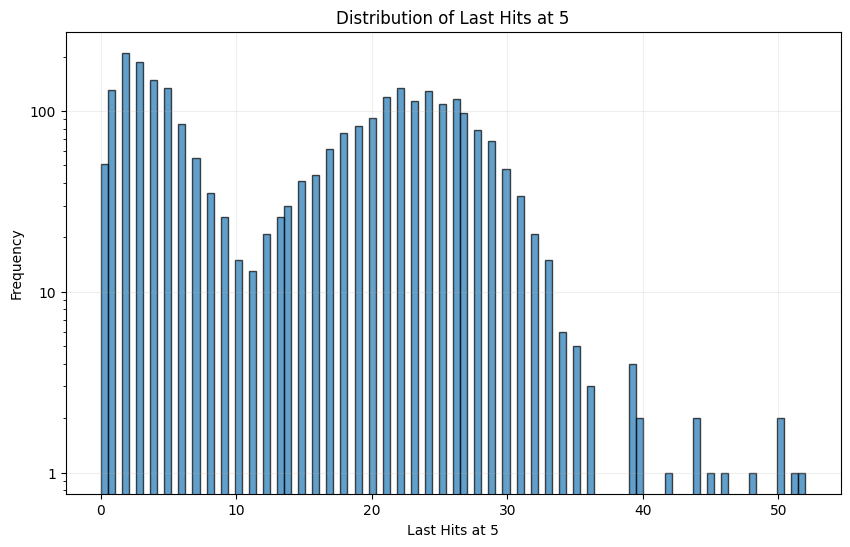

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Plot distribution of last_hits_at_5
plt.figure(figsize=(10, 6))

# Convert Polars Series to numpy array for matplotlib
last_hits_data = y_test['last_hits_at_5'].to_numpy()

# Create histogram with log scale
plt.hist(last_hits_data, bins=100, log=True, alpha=0.7, edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('Last Hits at 5')
plt.ylabel('Frequency')
plt.title('Distribution of Last Hits at 5')
plt.grid(True, alpha=0.2)

plt.show()

## Predictive model

### Regressor

In [ ]:
from catboost import CatBoostRegressor, Pool

# Convert to numpy arrays for CatBoost
X_train_np = X_train.to_pandas()
X_test_np = X_test.to_pandas()
y_train_np = y_train['last_hits_at_5'].to_pandas()
y_test_np = y_test['last_hits_at_5'].to_pandas()

model = CatBoostRegressor(
    iterations=2000, 
    loss_function='RMSE',
    depth=6, 
    verbose=100, 
    cat_features=categorical_features,
    random_seed=42
)

train_pool = Pool(data=X_train_np, label=y_train_np, cat_features=categorical_features)
test_pool = Pool(data=X_test_np, label=y_test_np, cat_features=categorical_features)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)
# bestTest = 3.633375834

Learning rate set to 0.045652
0:	learn: 9.9875845	test: 10.0832167	best: 10.0832167 (0)	total: 8.4ms	remaining: 16.8s
100:	learn: 3.6237709	test: 4.5129608	best: 4.5129608 (100)	total: 2.13s	remaining: 40.1s
200:	learn: 3.3548017	test: 4.4627486	best: 4.4623042 (198)	total: 6.27s	remaining: 56.1s
300:	learn: 3.1566660	test: 4.4361860	best: 4.4361860 (300)	total: 9.09s	remaining: 51.3s
400:	learn: 2.9898002	test: 4.4303645	best: 4.4303645 (400)	total: 12.7s	remaining: 50.8s
500:	learn: 2.8598940	test: 4.4210107	best: 4.4194521 (478)	total: 16.9s	remaining: 50.5s
600:	learn: 2.7359846	test: 4.4187746	best: 4.4171572 (573)	total: 20.4s	remaining: 47.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 4.417157171
bestIteration = 573

Shrink model to first 574 iterations.


In [18]:
import numpy as np

def accuracy_within_k(y_true, y_pred, k=1):
    return np.mean(np.abs(y_true - y_pred) <= k)

In [19]:
y_pred = model.predict(X_test_np)

acc1 = accuracy_within_k(y_test_np, y_pred.flatten(), k=1)
acc2 = accuracy_within_k(y_test_np, y_pred.flatten(), k=2)

print("Accuracy within ±1:", acc1)
print("Accuracy within ±2:", acc2)

# 0.2497, 0.440

Accuracy within ±1: 0.24067164179104478
Accuracy within ±2: 0.44813432835820893


In [20]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

# MSE
mse = mean_squared_error(y_test_np, y_pred)
print("MSE:", mse)

# RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test_np, y_pred))
print("RMSLE:", rmsle)

# MAE
mae = mean_absolute_error(y_test_np, y_pred)
print("MAE:", mae)

MSE: 19.511277476254115
RMSLE: 0.4079069707995252
MAE: 3.0256413879711572


### Classifier

In [74]:
from catboost import CatBoostClassifier, Pool

# Convert to numpy arrays for CatBoost
X_train_np = X_train.to_pandas()
X_test_np = X_test.to_pandas()
y_train_np = y_train['last_hits_at_5'].to_pandas()
y_test_np = y_test['last_hits_at_5'].to_pandas()

classifier_model = CatBoostClassifier(
    iterations=2000, 
    loss_function='MultiClass', 
    verbose=100, 
    cat_features=input_features,
    random_seed=42
)

train_pool = Pool(data=X_train_np, label=y_train_np, cat_features=input_features)
test_pool = Pool(data=X_test_np, label=y_test_np, cat_features=input_features)

classifier_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

# 2.718 = basic
# 2.683 = + messy friendly and enemy lanes
# 2.576 = improved lanes

CatBoostError: catboost/private/libs/algo/data.cpp:199: Dataset test #0 contains class label "50" that is not present in the learn dataset

In [67]:
# Predict: class labels
y_pred_class = classifier_model.predict(test_pool)

# Predict: class probabilities
y_pred_proba = classifier_model.predict_proba(test_pool)

# If you want an expected-value numeric prediction:
import numpy as np
classes = np.arange(y_pred_proba.shape[1])  # [0, 1, 2, ..., 36]
y_pred_expected = (y_pred_proba * classes).sum(axis=1)
y_pred_expected

CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.

In [36]:
# Calculate F1 score
from sklearn.metrics import f1_score
f1_score(y_test_np, y_pred_class, average='weighted')

NameError: name 'y_pred_class' is not defined

In [37]:
acc1 = accuracy_within_k(y_test_np, y_pred_class.flatten(), k=1)
acc2 = accuracy_within_k(y_test_np, y_pred_class.flatten(), k=2)

print("Accuracy within ±1:", acc1)
print("Accuracy within ±2:", acc2)

# 0.36, 0.54 (with heroes on lanes)

NameError: name 'y_pred_class' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

# MSE
mse = mean_squared_error(y_test_np, y_pred_class)
print("MSE:", mse)

# RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test_np, y_pred_class))
print("RMSLE:", rmsle)

# MAE
mae = mean_absolute_error(y_test_np, y_pred_class)
print("MAE:", mae)

# MAPE
mape = mean_absolute_percentage_error(y_test_np, y_pred_class)
print("MAPE:", mape)

### Manual evaluation

In [ ]:
# Manual test
import pandas as pd

# input_features = ['hero_name', 'player_account_id', 'assumed_lane_role', 'lane_partner', 'enemy_core', 'enemy_support']
test_hero_name = 'Sniper'
test_player_account_id = 106573901
test_assumed_lane_role = 2
test_lane_partner = 'Unknown'
test_enemy_core = 'Invoker'
test_enemy_support = 'Unknown'

result = model.predict(
    pd.DataFrame([[test_hero_name, test_player_account_id, test_assumed_lane_role, test_lane_partner, test_enemy_core, test_enemy_support]],
    columns=features)
)

print(result)

ValueError: 7 columns passed, passed data had 6 columns

In [21]:
predicted_df = y_test.clone()
# y_pred_expected
predicted_df = predicted_df.with_columns(pl.Series("predicted", y_pred))

predicted_df

last_hits_at_5,predicted
i64,f64
5,6.001591
10,5.784796
2,4.555865
5,4.294417
5,6.163812
…,…
21,23.378728
27,21.155173
33,23.472527


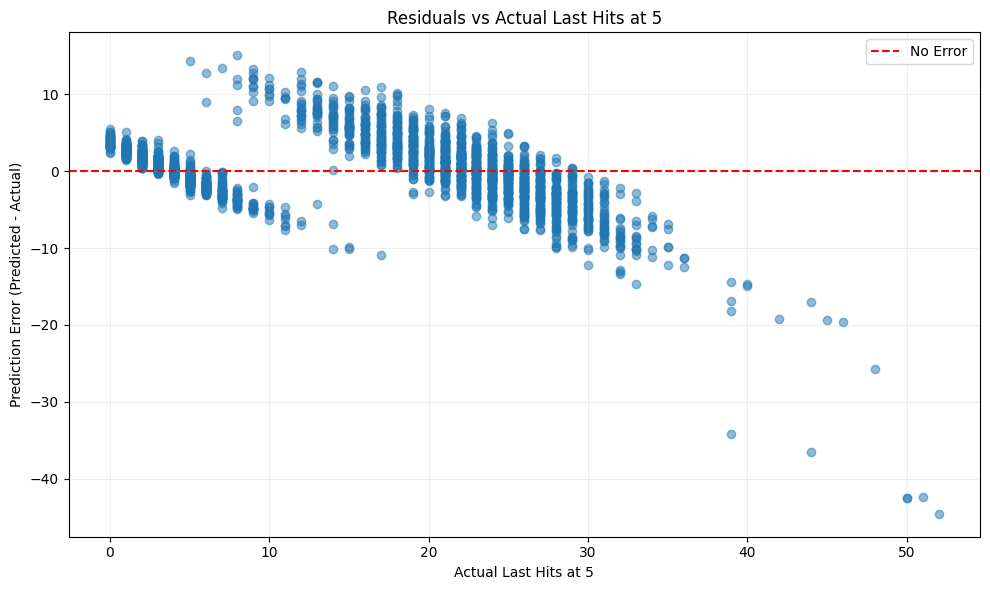

In [22]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = predicted_df['predicted'] - predicted_df['last_hits_at_5']

plt.figure(figsize=(10, 6))
plt.scatter(predicted_df['last_hits_at_5'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='No Error')

plt.xlabel('Actual Last Hits at 5')
plt.ylabel('Prediction Error (Predicted - Actual)')
plt.title('Residuals vs Actual Last Hits at 5')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()


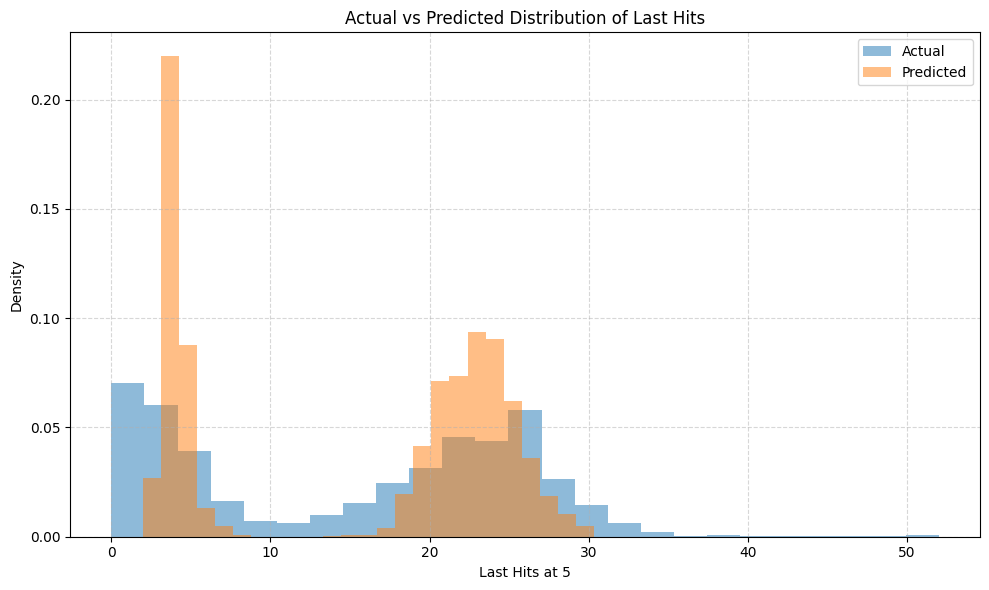

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(predicted_df['last_hits_at_5'], bins=25, alpha=0.5, label='Actual', density=True)
plt.hist(predicted_df['predicted'], bins=25, alpha=0.5, label='Predicted', density=True)

plt.xlabel('Last Hits at 5')
plt.ylabel('Density')
plt.title('Actual vs Predicted Distribution of Last Hits')
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


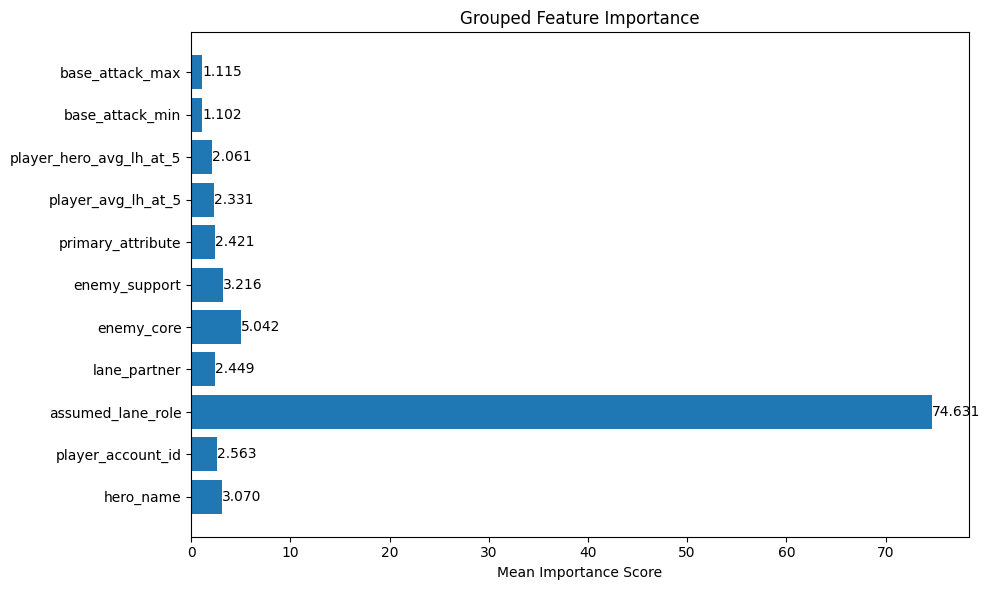

In [24]:
def plot_grouped_feature_importance(model):
    # Get feature importance scores
    feature_importance = model.get_feature_importance()

    # Create the plot
    fig, ax = plt.figure(figsize=(10, 6)), plt.axes()
    
    # Plot horizontal bar chart
    y_pos = np.arange(len(feature_importance))
    ax.barh(y_pos, list(feature_importance))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    
    plt.title('Grouped Feature Importance')
    plt.xlabel('Mean Importance Score')
    
    # Add value labels on the bars
    for i, v in enumerate(feature_importance):
        ax.text(v, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    return plt

# Usage:
plot_grouped_feature_importance(model)
plt.show()